# Sentiment Analysis

#### Importazione librerie

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from textblob import TextBlob
import matplotlib.pyplot as plt
from datetime import datetime
from tabulate import tabulate
# NLP libraries 
import nltk
import re
import ssl
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import os
#from scipy import stats as stat

### Importazione dataset twitter_tweets 

In [2]:
tweets_ds = pd.read_csv("../datasets/twitter/twitter_tweets.csv", chunksize=100000, lineterminator='\n', low_memory=False)
tweets_df = pd.concat(tweets_ds)

tweets_df.info()
tweets_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4792264 entries, 0 to 4792263
Data columns (total 8 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   tweet_id       int64 
 1   created_at     object
 2   author_id      int64 
 3   content        object
 4   retweet_count  int64 
 5   reply_count    int64 
 6   like_count     int64 
 7   quote_count    int64 
dtypes: int64(6), object(2)
memory usage: 292.5+ MB


(4792264, 8)

In [3]:
# Assicuriamo che non vi siano celle con valori nulli nelle colonne "created_at" e "content"
tweets_df.dropna(axis=0 ,subset=['created_at', 'content'],inplace = True)
tweets_df.reset_index(drop= True,inplace=True)
tweets_df.shape

(4792264, 8)

In [4]:
# Controllo dei valori nulli
null_values = tweets_df.isnull().sum()
print("Null values in each column:\n", null_values)

# Controllo dei valori duplicati
duplicate_rows = tweets_df.duplicated().sum()
print("Number of duplicate rows:", duplicate_rows)

Null values in each column:
 tweet_id         0
created_at       0
author_id        0
content          0
retweet_count    0
reply_count      0
like_count       0
quote_count      0
dtype: int64
Number of duplicate rows: 0


In [5]:
# Data cleaning 
tweets_df.drop_duplicates(inplace = True)
tweets_df.reset_index(drop=True,inplace=True)
tweets_df.shape

(4792264, 8)

In [6]:
# Impostazione dei tipi di colonna del dataset
tweets_df = tweets_df.convert_dtypes()
tweets_df.dtypes

tweet_id                  Int64
created_at       string[python]
author_id                 Int64
content          string[python]
retweet_count             Int64
reply_count               Int64
like_count                Int64
quote_count               Int64
dtype: object

In [7]:
# Controllare quali righe non hanno una data effettiva nella colonna "data"
def validate(date_text):
    errors = []
    for i,v in enumerate(date_text):
        try:
            datetime.strptime(v, '%Y-%m-%d %H:%M:%S')
        except ValueError:
            errors.append(i)
    return errors

In [8]:
# Stampa il numero di date non valide
errors = validate(tweets_df['created_at'])
print('There are '+ str(len(errors)) + ' values that are not actual dates in the created_at column')

There are 0 values that are not actual dates in the created_at column


### Date of first tweet and last tweet

In [9]:
# Primo e ultimo tweet in ordine temporale
tweets_df = tweets_df.sort_values(by='created_at')
primo_tweet = tweets_df.iloc[0]
ultimo_tweet = tweets_df.iloc[-1]

print("First tweet:")
print(primo_tweet['created_at'])

print("\nLast tweet:")
print(ultimo_tweet['created_at'])

First tweet:
2017-01-06 21:42:43

Last tweet:
2022-02-23 23:57:21


### Calcolo del punteggio totale dei tweet con pesi assegnati a variabili quali like, quote, reply e retweet. Ordinamento dei tweet in base al punteggio totale in ordine decrescente

In [10]:
# Definisci pesi per like, quote, reply e retweet
peso_like = 1
peso_reply = 2
peso_retweet = 3
peso_quote = 3

# Normalizza i valori dei vari aspetti
scaler = MinMaxScaler()
tweet_features = scaler.fit_transform(tweets_df[['like_count', 'quote_count', 'reply_count', 'retweet_count']])

# Calcola il punteggio totale per ciascun tweet
tweets_df['punteggio_totale'] = (
    tweet_features[:, 0] * peso_like + 
    tweet_features[:, 1] * peso_quote + 
    tweet_features[:, 2] * peso_reply + 
    tweet_features[:, 3] * peso_retweet 
)

# Ordina il dataFrame in base al punteggio totale in ordine decrescente (più influenti)
tweets_df_sorted_desc = tweets_df.sort_values(by='punteggio_totale', ascending=False)
tweets_df_sorted_desc['data'] = pd.to_datetime(tweets_df_sorted_desc['created_at']).dt.date

print("Tweet più influenti:")
print(tweets_df_sorted_desc[['tweet_id', 'like_count', 'quote_count', 'reply_count', 'retweet_count', 'punteggio_totale', 'data']])


Tweet più influenti:
                    tweet_id  like_count  quote_count  reply_count  \
2218350  1484230264293318663      192137        10642        12575   
871365   1454653822849011713       42682         2219        13137   
2116372  1486482496883625984       20161         7196         7281   
765175   1459164143626424321       33156         5759         8598   
3895838  1433903448215408646      238764         1564          472   
...                      ...         ...          ...          ...   
533263   1464353282776870924           0            0            0   
533262   1464353288657293313           0            0            0   
533261   1464353308005605378           0            0            0   
533260   1464353317547646984           0            0            0   
4792202  1496635323744280577           0            0            0   

         retweet_count  punteggio_totale        data  
2218350          13270          5.784699  2022-01-20  
871365           76411      

### Creazione grafico per il punteggio totale con mese ed anno

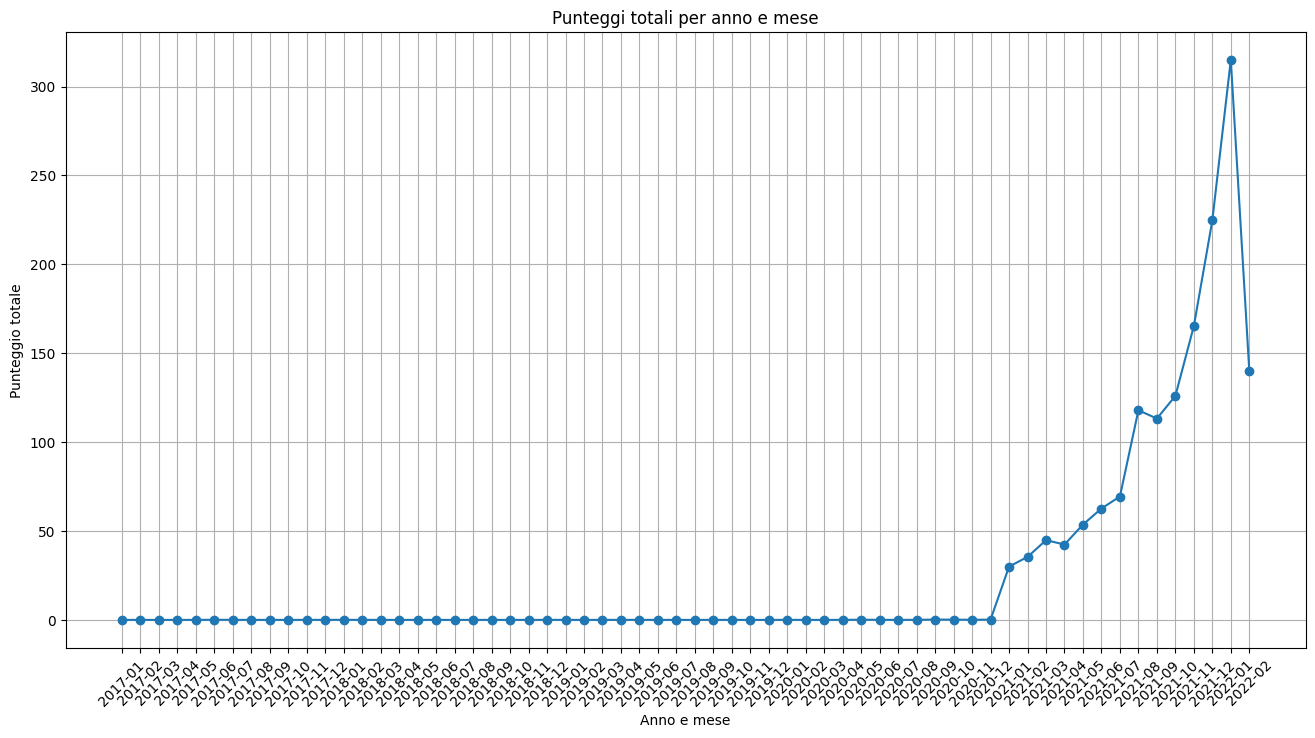

In [11]:
# Converti 'data' di nuovo in datetime per usare l'accessor dt
tweets_df_sorted_desc['data'] = pd.to_datetime(tweets_df_sorted_desc['data'])

# Calcola i punteggi totali per anno e mese
punteggi_totali_per_anno_mese = tweets_df_sorted_desc.groupby([tweets_df_sorted_desc['data'].dt.year, tweets_df_sorted_desc['data'].dt.month])['punteggio_totale'].sum()

# Converti l'indice in formato di stringa "anno-mese"
indice_stringa = punteggi_totali_per_anno_mese.index.map(lambda x: f"{x[0]}-{x[1]:02d}")

plt.figure(figsize=(16, 8)) 
plt.plot(indice_stringa, punteggi_totali_per_anno_mese.values, marker='o', linestyle='-')
plt.title('Punteggi totali per anno e mese')
plt.xlabel('Anno e mese')
plt.ylabel('Punteggio totale')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Filtering

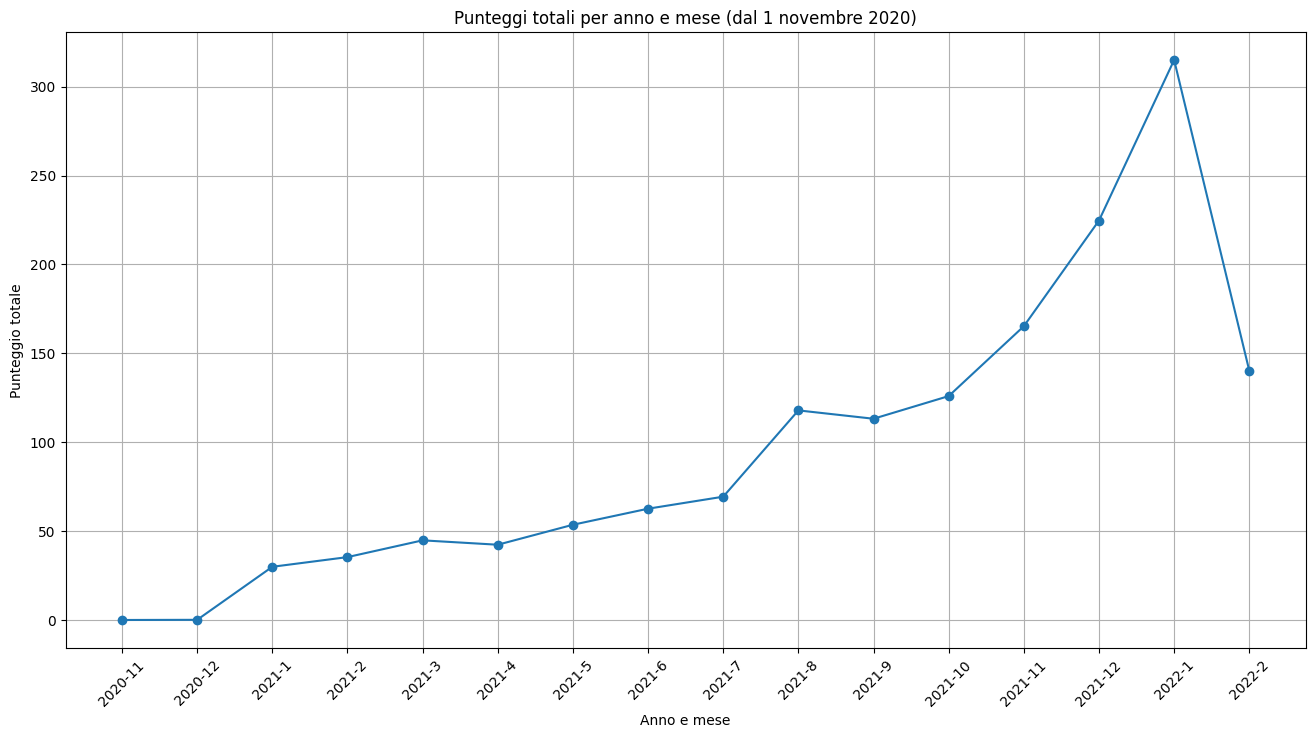

In [12]:
# Filtra i tweet dal 1 dicembre 2020 fino alla fine del dataset
tweets_filtrati = tweets_df_sorted_desc[tweets_df_sorted_desc['data'] >= pd.Timestamp('2020-11-01')]

# Calcola i punteggi totali per anno e mese dei tweet filtrati
punteggi_totali_per_anno_mese = tweets_filtrati.groupby([tweets_filtrati['data'].dt.year, tweets_filtrati['data'].dt.month])['punteggio_totale'].sum()

# Converti l'indice in formato di stringa "anno-mese"
indice_stringa = punteggi_totali_per_anno_mese.index.map(lambda x: f"{x[0]}-{x[1]}")

plt.figure(figsize=(16, 8))
plt.plot(indice_stringa, punteggi_totali_per_anno_mese.values, marker='o', linestyle='-')
plt.title('Punteggi totali per anno e mese (dal 1 novembre 2020)')
plt.xlabel('Anno e mese')
plt.ylabel('Punteggio totale')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [13]:
tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'], format='%Y-%m-%d %H:%M:%S')
tweets_df_final = tweets_df.loc[(tweets_df['created_at'] >= '2020-12-01')].reset_index(drop=True)
tweets_df_final.shape
# Visualizzare la forma del dataframe filtrato
# print(tweets_df_final.shape)

(4779585, 9)

### Importazione dataset twitter_tweet_hashtag 

In [14]:
hashtag_ds = pd.read_csv("../datasets/twitter/twitter_tweet_hashtag.csv", chunksize=100000, lineterminator='\n', low_memory=False)
hashtag_df = pd.concat(hashtag_ds)

hashtag_df.info()
hashtag_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7337482 entries, 0 to 7337481
Data columns (total 2 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   tweet_id  int64 
 1   hashtag   object
dtypes: int64(1), object(1)
memory usage: 112.0+ MB


(7337482, 2)

In [15]:
# Assicuriamo che non ci siano celle con valori nulli nelle colonne tweet_id e hashtag
hashtag_df.dropna(axis=0 ,subset=['tweet_id', 'hashtag'],inplace = True)
hashtag_df.reset_index(drop= True,inplace=True)
hashtag_df.shape

(7337480, 2)

In [16]:
# Controllo valori nulli
null_values = hashtag_df.isnull().sum()
print("Null values in each column:\n", null_values)

# Controllo valori duplicati
duplicate_rows = hashtag_df.duplicated().sum()
print("Number of duplicate rows:", duplicate_rows)

Null values in each column:
 tweet_id    0
hashtag     0
dtype: int64
Number of duplicate rows: 0


In [17]:
# Data cleaning 
hashtag_df.drop_duplicates(inplace = True)
hashtag_df.reset_index(drop=True,inplace=True)
hashtag_df.shape

(7337480, 2)

In [18]:
# Impostazione dei tipi di colonna del dataset
hashtag_df = hashtag_df.convert_dtypes()
hashtag_df.dtypes

tweet_id             Int64
hashtag     string[python]
dtype: object

### Hashtags list

In [19]:
# Assicura che la colonna 'hashtags' sia di tipo stringa
hashtag_df['hashtag'] = hashtag_df['hashtag'].astype(str)

# Crea una lista di tutti gli hashtag
all_hashtags = []
for hashtags_str in hashtag_df['hashtag']:
    # Rimuove eventuali caratteri indesiderati e divide per ottenere una lista di hashtag
    hashtags = [tag.strip("[]'") for tag in hashtags_str.split(', ')]
    all_hashtags.extend(hashtags)

# Rimuove eventuali caratteri speciali dagli hashtag
all_hashtags = [tag.strip("#") for tag in all_hashtags]

# Conta la frequenza degli hashtag
hashtags_frequenza = pd.Series(all_hashtags).value_counts()

# Numero totale di hashtag
total_hashtags = len(hashtags_frequenza)
print("Total number of hashtags:", total_hashtags)

# Filtra gli hashtag che contengono almeno una delle parole chiave relative agli NFT
nft_keywords = ["nft", "cryptopunks", "bayc", "nfts", "nftcommunity", "nftart", "nftcollector", "opensea", "ethereum", "cryptopunk"]
filtered_hashtags = hashtags_frequenza[hashtags_frequenza.index.str.contains('|'.join(nft_keywords))]

# Stampa gli hashtag rilevanti insieme alla loro frequenza
print("Hashtags related to NFT and their counts:")
print(filtered_hashtags)


Total number of hashtags: 185131
Hashtags related to NFT and their counts:
nft                517794
cryptopunks        310915
bayc               306206
nfts               287180
nftcommunity       224366
                    ...  
nftchampion             1
parodynft               1
nftfollectibles         1
nftthaiㅜ                1
nftcn                   1
Name: count, Length: 10024, dtype: int64


### Hashtags più influenti visibili graficamente

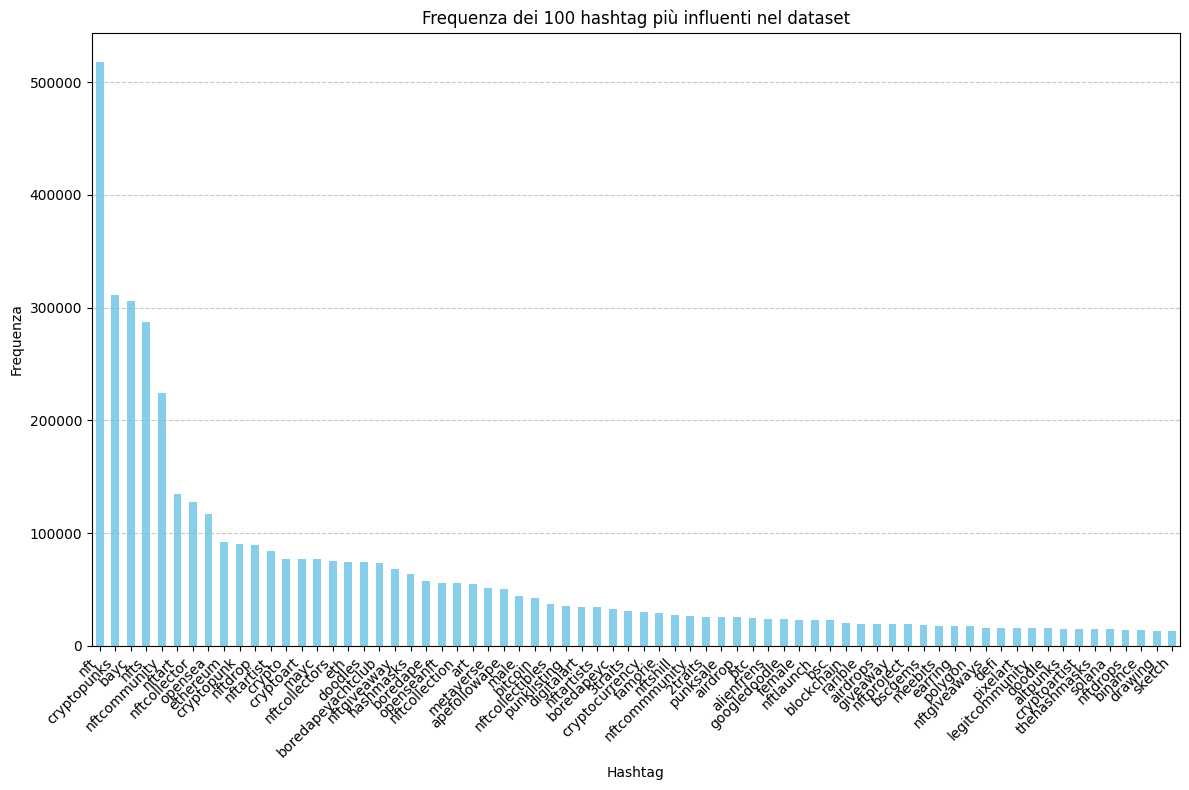

In [20]:
# Per vedere gli hashtags più frequenti nel grafico (70)
hashtags_influenti = hashtags_frequenza.head(70)

plt.figure(figsize=(12, 8))
hashtags_influenti.plot(kind='bar', color='skyblue')
plt.title('Frequenza dei 100 hashtag più influenti nel dataset')
plt.xlabel('Hashtag')
plt.ylabel('Frequenza')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Filtraggio lista hashtag

In [21]:
# Crea un dataframe dai conti degli hashtag
hashtag_df = pd.DataFrame(hashtags_frequenza.items(), columns=['hashtag', 'count'])
# Ordina il dataframe per conteggio
hashtag_df = hashtag_df.sort_values(by='count', ascending=False)

# Prendi solo i primi 25 hashtag
top_hashtags = hashtag_df.head(25)
print("Top 25 Hashtags:")
print(top_hashtags)

Top 25 Hashtags:
              hashtag   count
0                 nft  517794
1         cryptopunks  310915
2                bayc  306206
3                nfts  287180
4        nftcommunity  224366
5              nftart  134723
6        nftcollector  127437
7             opensea  117422
8            ethereum   92566
9          cryptopunk   90684
10            nftdrop   89965
11          nftartist   83959
12             crypto   77336
13          cryptoart   76762
14               mayc   76687
15      nftcollectors   75089
16                eth   74478
17            doodles   74450
18  boredapeyachtclub   73813
19        nftgiveaway   68274
20          hashmasks   63935
21           boredape   57365
22         openseanft   55646
23      nftcollection   55617
24                art   54583


<Figure size 1200x600 with 0 Axes>

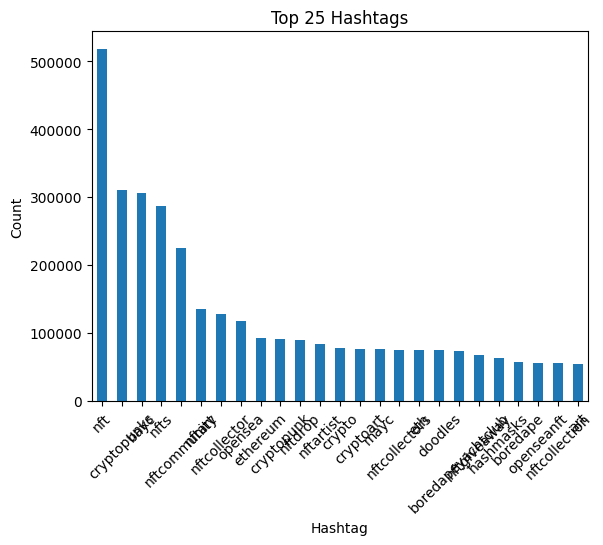

In [22]:
# Visualizza i primi 25 hashtag graficamente
plt.figure(figsize=(12, 6))
top_hashtags.plot(kind='bar', x='hashtag', y='count', legend=False)
plt.title('Top 25 Hashtags')
plt.ylabel('Count')
plt.xlabel('Hashtag')
plt.xticks(rotation=45)
plt.show()

### Analisi temporale: n tweet per giorno

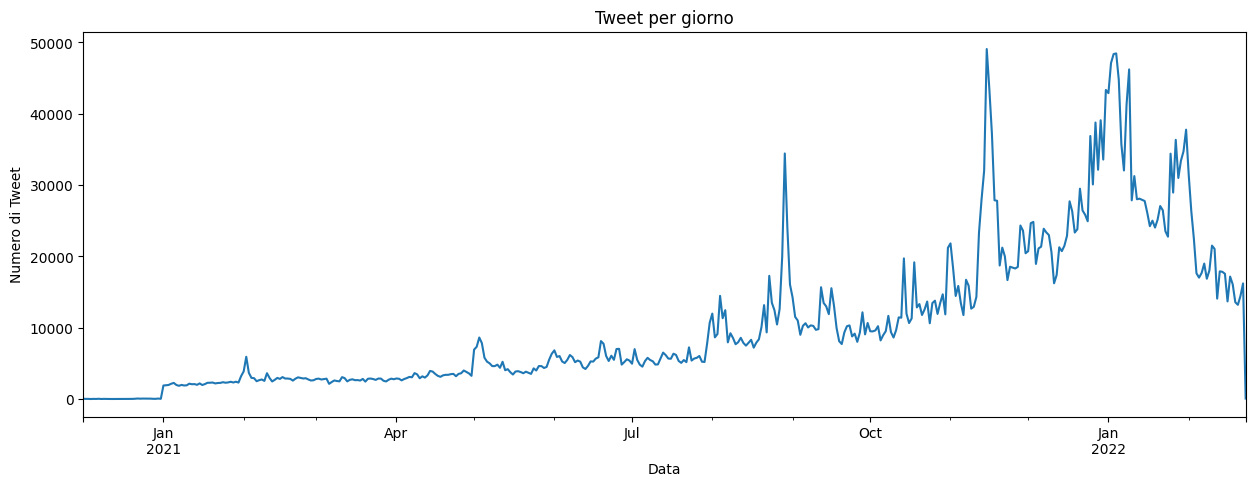

In [23]:
# Analisi temporale per il numero di tweet per giorno
tweets_df_final.set_index('created_at', inplace=True)

# Resample per giorno e conta i tweet
tweets_per_day = tweets_df_final['tweet_id'].resample('D').count()

plt.figure(figsize=(15, 5))
tweets_per_day.plot()
plt.title('Tweet per giorno')
plt.ylabel('Numero di Tweet')
plt.xlabel('Data')
plt.show()


### Contare e visualizzare i Tweet con almeno un hashtag che ci interessano (top hashtags)

In [24]:
# Definisci la funzione per contare il numero di hashtag di interesse in un tweet
def count_interest_hashtags(tweet_content):
    count = sum(1 for hashtag in top_hashtags['hashtag'] if hashtag in tweet_content)
    return count

# Applica la funzione per contare gli hashtag a ogni tweet
tweets_df_final['num_interest_hashtags'] = tweets_df_final['content'].apply(count_interest_hashtags)

# Conta il numero di tweet che contengono almeno uno degli hashtag di interesse
num_tweets_with_interest_hashtags = tweets_df_final[tweets_df_final['num_interest_hashtags'] > 0].shape[0]
print(f"Number of tweets with at least one interest hashtag: {num_tweets_with_interest_hashtags}")


Number of tweets with at least one interest hashtag: 2604393


### Filtraggio tweets df final con solo almeno uno degli hashtag di interesse salvati nella variabile tweets_with_interest_hashtags

In [25]:
# Filtra il DataFrame per includere solo i tweet con almeno uno degli hashtag di interesse
tweets_with_interest_hashtags = tweets_df_final[tweets_df_final['num_interest_hashtags'] > 0]

# Visualizza il DataFrame risultante
print(tweets_with_interest_hashtags)

# Controllo sul numero di tweet che contiene la nuova variabile
num_tweets_with_interest_hashtags = tweets_with_interest_hashtags.shape[0]
print("Numero di tweet nella variabile 'tweets_with_interest_hashtags':", num_tweets_with_interest_hashtags)

                                tweet_id            author_id  \
created_at                                                      
2020-12-01 00:06:03  1333562970291511299            722037084   
2020-12-01 00:07:12  1333563259174187009            722037084   
2020-12-01 00:53:00  1333574785998217217            594609832   
2020-12-01 00:53:46  1333574979343015936            594609832   
2020-12-01 01:01:07  1333576830297780225             25276592   
...                                  ...                  ...   
2022-02-23 23:10:11  1496623453574737927  1315596439389691904   
2022-02-23 23:13:35  1496624306650062854  1364796117851000833   
2022-02-23 23:38:51  1496630664547995653  1364796117851000833   
2022-02-23 23:39:03  1496630715227664388  1035703436300283906   
2022-02-23 23:57:21  1496635323744280577            732899923   

                                                               content  \
created_at                                                               
2020-1

### Visualizzazione della distribuzione dei Tweet con e senza hashtag di Interesse
### NB: Vedere quanti tweets possiedono gli hashtag del nostro filtraggio rispetto a quelli totali

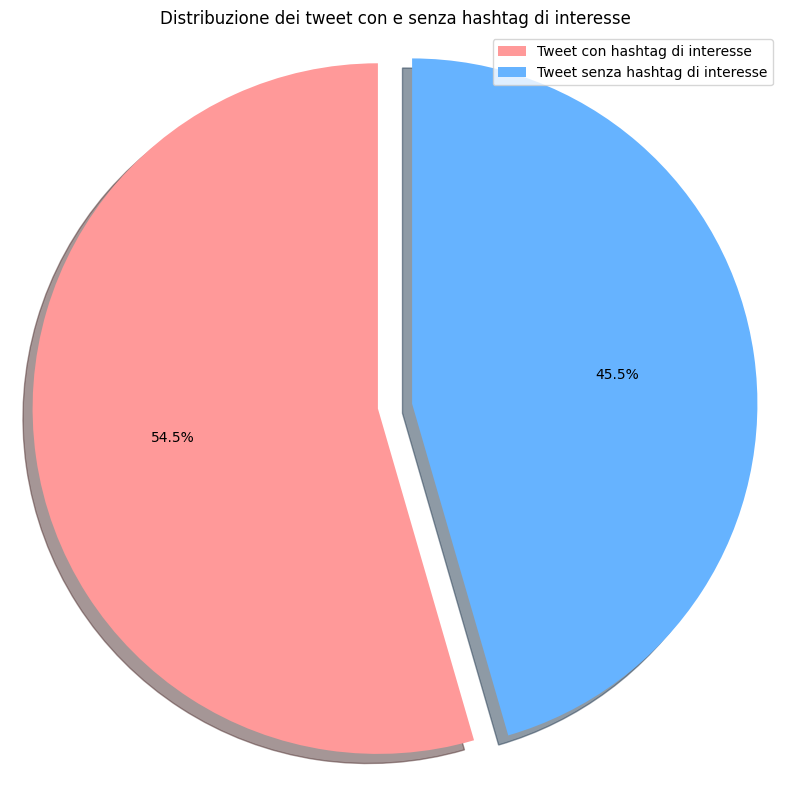

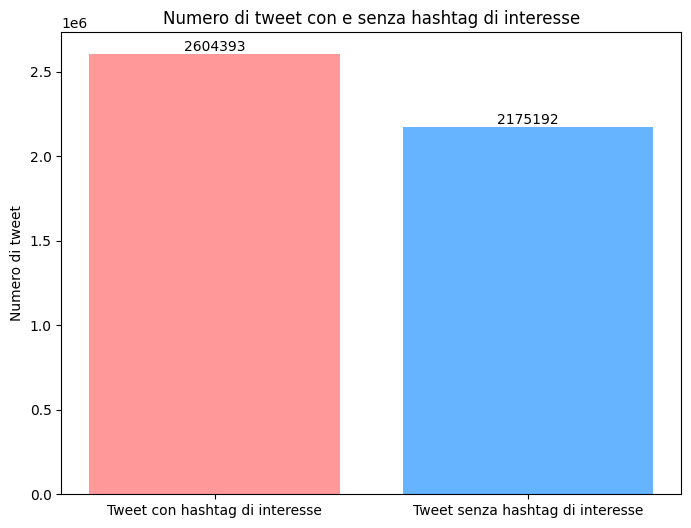

In [33]:
# Conta il numero totale di tweet
total_tweets = tweets_df_final.shape[0]

# Crea i dati per la visualizzazione
labels = ['Tweet con hashtag di interesse', 'Tweet senza hashtag di interesse']
sizes = [num_tweets_with_interest_hashtags, total_tweets - num_tweets_with_interest_hashtags]
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0) 

# Grafico a torta
plt.figure(figsize=(8,8))
plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')  
plt.title('Distribuzione dei tweet con e senza hashtag di interesse')
plt.legend(labels=['Tweet con hashtag di interesse', 'Tweet senza hashtag di interesse'], loc='upper right')
plt.tight_layout()
plt.show()

# Grafico a barre
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, sizes, color=colors)
plt.ylabel('Numero di tweet')
plt.title('Numero di tweet con e senza hashtag di interesse')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom')

plt.show()

### Tweet con il maggior numero di hashtag di interesse (indicati precedentemente)

In [30]:
# Trova il massimo numero di hashtag di interesse tra tutti i tweet
max_interest_hashtags = tweets_df_final['num_interest_hashtags'].max()

# Filtra i tweet che hanno il massimo numero di hashtag di interesse
tweets_with_max_interest_hashtags = tweets_df_final[tweets_df_final['num_interest_hashtags'] == max_interest_hashtags].copy()

# Seleziona solo le colonne desiderate
selected_columns = ['tweet_id', 'author_id', 'content']

# Crea una copia dei dati per evitare SettingWithCopyWarning
tweets_with_max_interest_hashtags_selected = tweets_with_max_interest_hashtags[selected_columns].copy()

# Aggiungi una colonna per mostrare gli hashtag citati in ciascun tweet
tweets_with_max_interest_hashtags_selected['mentioned_hashtags'] = tweets_with_max_interest_hashtags_selected['content'].apply(lambda x: [tag.strip("#") for tag in x.split() if tag.startswith("#")])

# Ordina i tweet per data di creazione in ordine decrescente
tweets_with_max_interest_hashtags_selected = tweets_with_max_interest_hashtags_selected.sort_index(ascending=False)

# Visualizza i tweet con il massimo numero di hashtag di interesse e gli hashtag menzionati
print("Tweets with the maximum number of interest hashtags and mentioned hashtags:")
print(tweets_with_max_interest_hashtags_selected)

# Calcola il numero di tweet con il massimo numero di hashtag di interesse
num_tweets_with_max_interest_hashtags = len(tweets_with_max_interest_hashtags_selected)
print(f"Number of tweets with the maximum number of interest hashtags: {num_tweets_with_max_interest_hashtags}")

# Raggruppa i tweet per autore e contali
author_tweet_counts = tweets_with_max_interest_hashtags_selected.groupby('author_id').size().sort_values(ascending=False)

# Visualizza i tweet con il massimo numero di hashtag di interesse per ogni autore
print("Tweets with the maximum number of interest hashtags by author:")
print(author_tweet_counts)

# Visualizza il numero di autori con il massimo numero di tweet
print(f"Number of authors with the maximum number of interest hashtags: {len(author_tweet_counts)}")



Tweets with the maximum number of interest hashtags and mentioned hashtags:
                                tweet_id            author_id  \
created_at                                                      
2021-10-09 15:04:12  1446854011953557509  1437073473365553157   

                                                               content  \
created_at                                                               
2021-10-09 15:04:12  @valleyTheCat @Ape_ethereum The bounty hunters...   

                                                    mentioned_hashtags  
created_at                                                              
2021-10-09 15:04:12  [nft, nfts, nftart, nftartist, nftcollector, n...  
Number of tweets with the maximum number of interest hashtags: 1
Tweets with the maximum number of interest hashtags by author:
author_id
1437073473365553157    1
dtype: int64
Number of authors with the maximum number of interest hashtags: 1


### Pulizia testo in preparazione alla Sentiment Analysis ###

In [31]:
# Pulizia del testo
tweets_with_interest_hashtags['content'] = tweets_with_interest_hashtags['content'].str.replace("(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"," ")
df_tweets_sentiment = tweets_with_interest_hashtags.copy()
df_tweets_sentiment.head()

<>:2: SyntaxWarning: invalid escape sequence '\['
<>:2: SyntaxWarning: invalid escape sequence '\['
/var/folders/ht/ykt5nd_d1w55_nvpcjzwqvmw0000gn/T/ipykernel_5095/3998678847.py:2: SyntaxWarning: invalid escape sequence '\['
  tweets_with_interest_hashtags['content'] = tweets_with_interest_hashtags['content'].str.replace("(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"," ")
/var/folders/ht/ykt5nd_d1w55_nvpcjzwqvmw0000gn/T/ipykernel_5095/3998678847.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_with_interest_hashtags['content'] = tweets_with_interest_hashtags['content'].str.replace("(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"," ")


,tweet_id,author_id,content,retweet_count,reply_count,like_count,quote_count,punteggio_totale,num_interest_hashtags
created_at,,,,,,,,,
2020-12-01 00:06:03,1333562970291511299,722037084,I am participating in an #epic #LitecoinCash #...,0,0,0,0,0.0,3
2020-12-01 00:07:12,1333563259174187009,722037084,Join @litecoincash Discord: https://t.co/C7qLS...,0,0,0,0,0.0,2
2020-12-01 00:53:00,1333574785998217217,594609832,I am participating in an #epic #LitecoinCash #...,0,0,0,0,0.0,3
2020-12-01 00:53:46,1333574979343015936,594609832,Join @litecoincash Discord: https://t.co/ahRtO...,0,0,0,0,0.0,2
2020-12-01 01:01:07,1333576830297780225,25276592,I am participating in an #epic #LitecoinCash #...,0,0,0,0,0.0,3


In [32]:
# Disabilita la verifica SSL per scaricare i token di nltk, altrimenti non funziona
ssl._create_default_https_context = ssl._create_unverified_context

In [33]:
# punkt serve per tokenizzare il testo e pulirlo
nltk.download('punkt')
# stopwords serve per rimuovere le parole comuni che non sono rilevanti per l'analisi
nltk.download('stopwords')
# wordnet serve per le operazioni di stemming
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/martinadaghia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/martinadaghia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/martinadaghia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [34]:
# Tokenizzazione per dividere il testo in parole per poterle analizzare singolarmente
df_tweets_sentiment['content'] = df_tweets_sentiment.apply(lambda row: word_tokenize(row['content']), axis=1)
df_tweets_sentiment.head()

,tweet_id,author_id,content,retweet_count,reply_count,like_count,quote_count,punteggio_totale,num_interest_hashtags
created_at,,,,,,,,,
2020-12-01 00:06:03,1333562970291511299,722037084,"[I, am, participating, in, an, #, epic, #, Lit...",0,0,0,0,0.0,3
2020-12-01 00:07:12,1333563259174187009,722037084,"[Join, @, litecoincash, Discord, :, https, :, ...",0,0,0,0,0.0,2
2020-12-01 00:53:00,1333574785998217217,594609832,"[I, am, participating, in, an, #, epic, #, Lit...",0,0,0,0,0.0,3
2020-12-01 00:53:46,1333574979343015936,594609832,"[Join, @, litecoincash, Discord, :, https, :, ...",0,0,0,0,0.0,2
2020-12-01 01:01:07,1333576830297780225,25276592,"[I, am, participating, in, an, #, epic, #, Lit...",0,0,0,0,0.0,3


In [35]:
# Rimozione delle stopwords
stopwords = set(stopwords.words('english'))

In [36]:
df_tweets_sentiment['content'] = df_tweets_sentiment.apply(lambda row: (" ".join([word for word in row['content'] if word not in stopwords])),axis=1)
df_tweets_sentiment.head() 

,tweet_id,author_id,content,retweet_count,reply_count,like_count,quote_count,punteggio_totale,num_interest_hashtags
created_at,,,,,,,,,
2020-12-01 00:06:03,1333562970291511299,722037084,I participating # epic # LitecoinCash # giveaw...,0,0,0,0,0.0,3
2020-12-01 00:07:12,1333563259174187009,722037084,Join @ litecoincash Discord : https : //t.co/C...,0,0,0,0,0.0,2
2020-12-01 00:53:00,1333574785998217217,594609832,I participating # epic # LitecoinCash # giveaw...,0,0,0,0,0.0,3
2020-12-01 00:53:46,1333574979343015936,594609832,Join @ litecoincash Discord : https : //t.co/a...,0,0,0,0,0.0,2
2020-12-01 01:01:07,1333576830297780225,25276592,I participating # epic # LitecoinCash # giveaw...,0,0,0,0,0.0,3


In [37]:
# Lemmatizzazione per ridurre le parole alla loro forma base
# lemmatizer = WordNetLemmatizer()
# df_tweets_sentiment['content'] = df_tweets_sentiment.apply(lambda row: [lemmatizer.lemmatize(word) for word in row['content']], axis=1)

### Popolarità e soggettività dei tweet ###

In [38]:
# Calcola la popolarità e la soggettività di ciascun tweet
df_tweets_sentiment[['polarity', 'subjectivity']] = df_tweets_sentiment['content'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
df_tweets_sentiment.head()

,tweet_id,author_id,content,retweet_count,reply_count,like_count,quote_count,punteggio_totale,num_interest_hashtags,polarity,subjectivity
created_at,,,,,,,,,,,
2020-12-01 00:06:03,1333562970291511299,722037084,I participating # epic # LitecoinCash # giveaw...,0,0,0,0,0.0,3,0.375000,0.6
2020-12-01 00:07:12,1333563259174187009,722037084,Join @ litecoincash Discord : https : //t.co/C...,0,0,0,0,0.0,2,0.208333,0.4
2020-12-01 00:53:00,1333574785998217217,594609832,I participating # epic # LitecoinCash # giveaw...,0,0,0,0,0.0,3,0.375000,0.6
2020-12-01 00:53:46,1333574979343015936,594609832,Join @ litecoincash Discord : https : //t.co/a...,0,0,0,0,0.0,2,0.208333,0.4
2020-12-01 01:01:07,1333576830297780225,25276592,I participating # epic # LitecoinCash # giveaw...,0,0,0,0,0.0,3,0.375000,0.6


### Assegnazione del sentiment

In [39]:
# Crea una nuova colonna 'Sentiment' basata sulla polarità
df_tweets_sentiment['Sentiment'] = df_tweets_sentiment['polarity'].apply(lambda x: "Positive" if x > 0 else ("Negative" if x < 0 else "Neutral"))
# Visualizza i primi risultati
df_tweets_sentiment.head()


,tweet_id,author_id,content,retweet_count,reply_count,like_count,quote_count,punteggio_totale,num_interest_hashtags,polarity,subjectivity,Sentiment
created_at,,,,,,,,,,,,
2020-12-01 00:06:03,1333562970291511299,722037084,I participating # epic # LitecoinCash # giveaw...,0,0,0,0,0.0,3,0.375000,0.6,Positive
2020-12-01 00:07:12,1333563259174187009,722037084,Join @ litecoincash Discord : https : //t.co/C...,0,0,0,0,0.0,2,0.208333,0.4,Positive
2020-12-01 00:53:00,1333574785998217217,594609832,I participating # epic # LitecoinCash # giveaw...,0,0,0,0,0.0,3,0.375000,0.6,Positive
2020-12-01 00:53:46,1333574979343015936,594609832,Join @ litecoincash Discord : https : //t.co/a...,0,0,0,0,0.0,2,0.208333,0.4,Positive
2020-12-01 01:01:07,1333576830297780225,25276592,I participating # epic # LitecoinCash # giveaw...,0,0,0,0,0.0,3,0.375000,0.6,Positive


In [40]:
# Per poter visualizzare i risultati e scorrere i sentimenti dei vari tweet
print(df_tweets_sentiment)

                                tweet_id            author_id  \
created_at                                                      
2020-12-01 00:06:03  1333562970291511299            722037084   
2020-12-01 00:07:12  1333563259174187009            722037084   
2020-12-01 00:53:00  1333574785998217217            594609832   
2020-12-01 00:53:46  1333574979343015936            594609832   
2020-12-01 01:01:07  1333576830297780225             25276592   
...                                  ...                  ...   
2022-02-23 23:10:11  1496623453574737927  1315596439389691904   
2022-02-23 23:13:35  1496624306650062854  1364796117851000833   
2022-02-23 23:38:51  1496630664547995653  1364796117851000833   
2022-02-23 23:39:03  1496630715227664388  1035703436300283906   
2022-02-23 23:57:21  1496635323744280577            732899923   

                                                               content  \
created_at                                                               
2020-1

### Formattazione delle date

In [41]:
# Resettare l'indice 'created_at' 
df_tweets_sentiment = df_tweets_sentiment.reset_index()

# Converte la colonna 'created_at' in formato datetime
df_tweets_sentiment['created_at'] = pd.to_datetime(df_tweets_sentiment['created_at'], format='%Y-%m-%d %H:%M:%S')
df_tweets_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2604393 entries, 0 to 2604392
Data columns (total 13 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   created_at             datetime64[ns]
 1   tweet_id               Int64         
 2   author_id              Int64         
 3   content                object        
 4   retweet_count          Int64         
 5   reply_count            Int64         
 6   like_count             Int64         
 7   quote_count            Int64         
 8   punteggio_totale       float64       
 9   num_interest_hashtags  int64         
 10  polarity               float64       
 11  subjectivity           float64       
 12  Sentiment              object        
dtypes: Int64(6), datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 273.2+ MB


### Filtraggio delle date

In [42]:
# Imposta la data di inizio e fine per filtrare i tweet nel DataFrame con i periodi più importanti analizzati precedentemente
first_date = pd.to_datetime('2020-12-01')
last_date = pd.to_datetime('2022-02-23') # Data dell'ultimo tweet nel dataset
# Filtra i tweet per il periodo specificato
df_tweets_sentiment_period = df_tweets_sentiment.loc[(df_tweets_sentiment['created_at'] >= first_date) & (df_tweets_sentiment['created_at'] <= last_date)].reset_index(drop=True)
df_tweets_sentiment_period.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2604360 entries, 0 to 2604359
Data columns (total 13 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   created_at             datetime64[ns]
 1   tweet_id               Int64         
 2   author_id              Int64         
 3   content                object        
 4   retweet_count          Int64         
 5   reply_count            Int64         
 6   like_count             Int64         
 7   quote_count            Int64         
 8   punteggio_totale       float64       
 9   num_interest_hashtags  int64         
 10  polarity               float64       
 11  subjectivity           float64       
 12  Sentiment              object        
dtypes: Int64(6), datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 273.2+ MB


### Analisi del sentiment per ciascun giorno

In [43]:
# Raggruppa per data e sentiment e conta il numero di tweet per ciascuna combinazione
grouped_data = df_tweets_sentiment_period.groupby(['created_at', 'Sentiment']).size().reset_index(name='tweet_count')
print(grouped_data)

                 created_at Sentiment  tweet_count
0       2020-12-01 00:06:03  Positive            1
1       2020-12-01 00:07:12  Positive            1
2       2020-12-01 00:53:00  Positive            1
3       2020-12-01 00:53:46  Positive            1
4       2020-12-01 01:01:07  Positive            1
...                     ...       ...          ...
2517285 2022-02-22 23:59:19  Negative            1
2517286 2022-02-22 23:59:19  Positive            1
2517287 2022-02-22 23:59:29  Positive            1
2517288 2022-02-22 23:59:41   Neutral            1
2517289 2022-02-22 23:59:47  Positive            1

[2517290 rows x 3 columns]


### Distribuzione del sentiment nel tempo

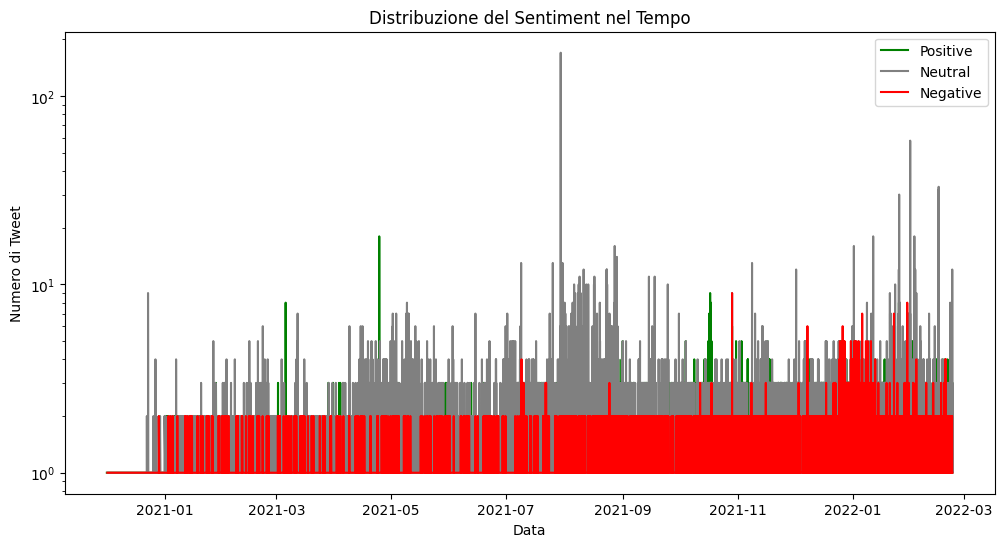

In [44]:
# Definiamo i colori per i sentimenti
colors = {'Positive': 'green', 'Neutral': 'gray', 'Negative': 'red'}

# Creazione del grafico per la distribuzione del sentiment nel tempo
plt.figure(figsize=(12, 6))

for sentiment in ['Positive', 'Neutral', 'Negative']:
    data = grouped_data[grouped_data['Sentiment'] == sentiment]
    plt.plot(data['created_at'], data['tweet_count'], label=sentiment, color=colors[sentiment])

plt.title('Distribuzione del Sentiment nel Tempo')
plt.xlabel('Data')
plt.ylabel('Numero di Tweet')
plt.yscale('log')  # Usa una scala logaritmica sull'asse y
plt.legend()
plt.show()

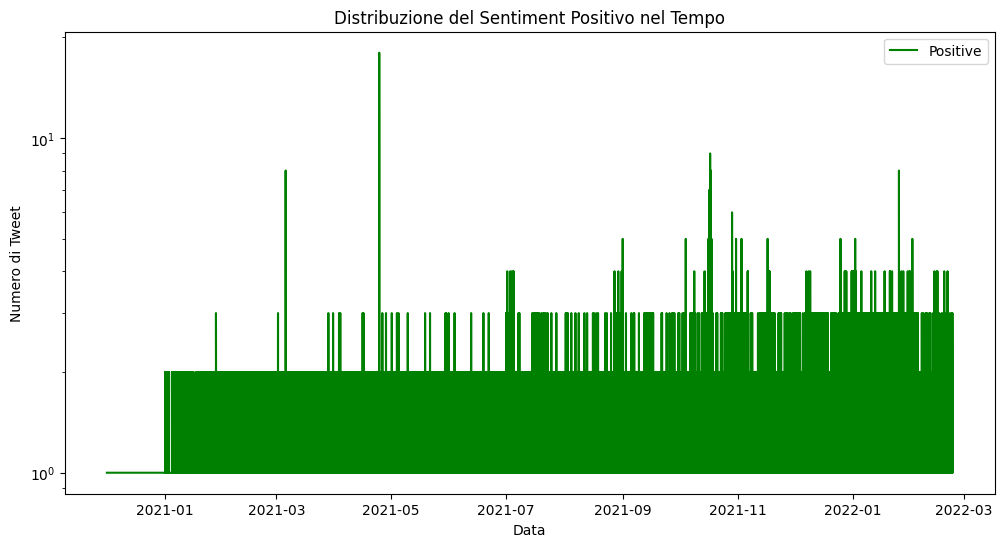

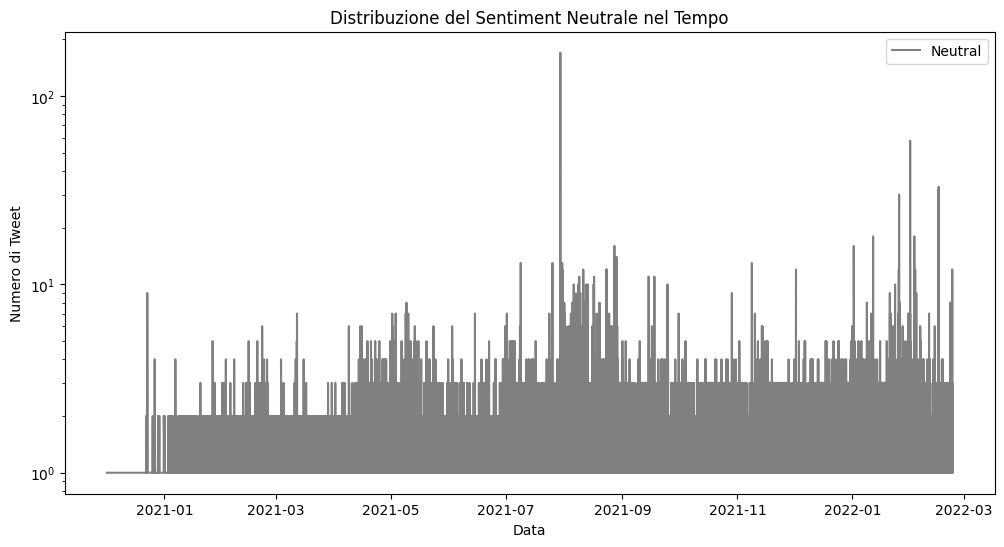

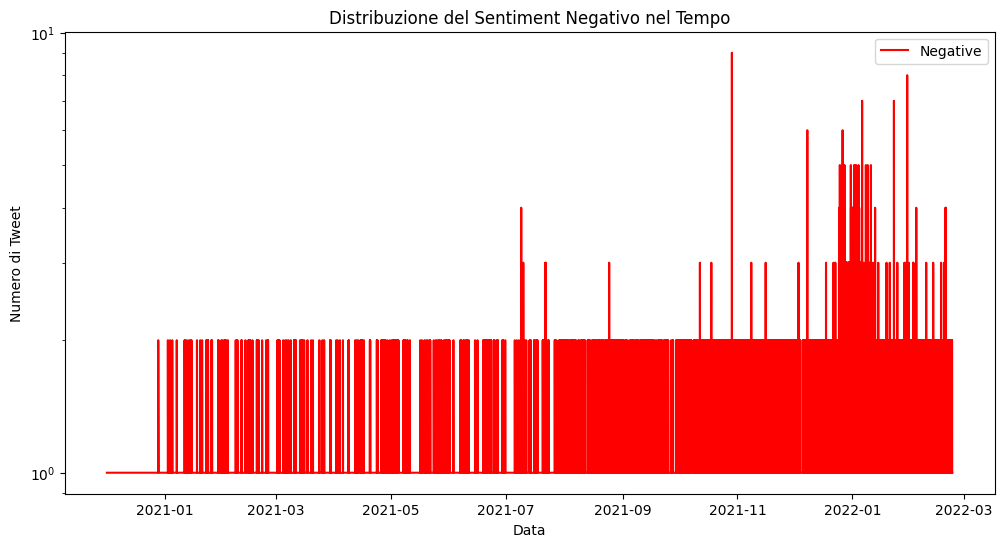

In [45]:
# Creazione del grafico per i picchi verdi (Positive)
plt.figure(figsize=(12, 6))
data_positive = grouped_data[grouped_data['Sentiment'] == 'Positive']
plt.plot(data_positive['created_at'], data_positive['tweet_count'], label='Positive', color=colors['Positive'])
plt.title('Distribuzione del Sentiment Positivo nel Tempo')
plt.xlabel('Data')
plt.ylabel('Numero di Tweet')
plt.yscale('log')
plt.legend()
plt.show()

# Creazione del grafico per i picchi grigi (Neutral)
plt.figure(figsize=(12, 6))
data_neutral = grouped_data[grouped_data['Sentiment'] == 'Neutral']
plt.plot(data_neutral['created_at'], data_neutral['tweet_count'], label='Neutral', color=colors['Neutral'])
plt.title('Distribuzione del Sentiment Neutrale nel Tempo')
plt.xlabel('Data')
plt.ylabel('Numero di Tweet')
plt.yscale('log')
plt.legend()
plt.show()

# Creazione del grafico per i picchi rossi (Negative)
plt.figure(figsize=(12, 6))
data_negative = grouped_data[grouped_data['Sentiment'] == 'Negative']
plt.plot(data_negative['created_at'], data_negative['tweet_count'], label='Negative', color=colors['Negative'])
plt.title('Distribuzione del Sentiment Negativo nel Tempo')
plt.xlabel('Data')
plt.ylabel('Numero di Tweet')
plt.yscale('log')
plt.legend()
plt.show()

### Grafico a torta per visualizzare la quantità di Tweets con sentiment positivo, negativo e neutrale

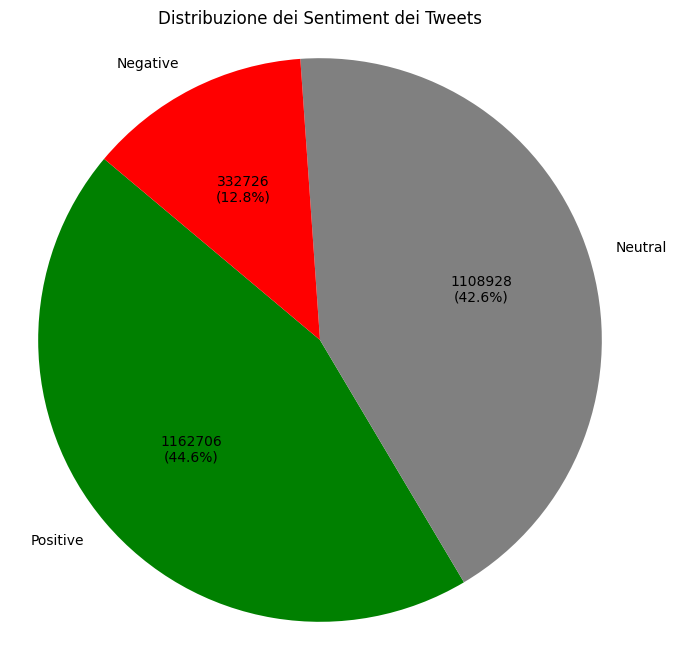

In [46]:
# Conta il numero totale di tweet per ogni tipo di sentiment
sentiment_counts = df_tweets_sentiment_period['Sentiment'].value_counts()

# Definisci i colori per i sentimenti
colors = {'Positive': 'green', 'Neutral': 'gray', 'Negative': 'red'}

# Crea una lista di colori corrispondente all'ordine dei sentimenti
sentiment_colors = [colors[sentiment] for sentiment in sentiment_counts.index]

plt.figure(figsize=(8, 8))
plt.pie(
    sentiment_counts, 
    labels=sentiment_counts.index, 
    colors=sentiment_colors, 
    autopct=lambda p: f'{p * sentiment_counts.sum() / 100:.0f}\n({p:.1f}%)', 
    startangle=140
)
plt.title('Distribuzione dei Sentiment dei Tweets')
plt.axis('equal') 
plt.show()

### Salvataggio dataframe per confrontare picchi dei tweet e degli nft

In [47]:
# Percorso della cartella "datasets"
datasets_path = '../datasets/'

# Percorso della cartella "dataframes"
dataframes_path = '../dataframes'

# Creazione della cartella 'dataframes' se non esiste
os.makedirs(dataframes_path, exist_ok=True)

# Salvataggio del dataframe df_tweets_sentiment_period in un file CSV nella cartella 'dataframes'
df_tweets_sentiment_period.to_csv(os.path.join(dataframes_path, 'tweets_sentiment_df.csv'), index=False)